In [2]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
mt5.initialize()
# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

In [150]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1[['time','open', 'high', 'low', 'close']].set_index('time')

def compute_spread(p1, p2, tf, x):
    data1 = get_rates(p1, tf, x)
    data2 = get_rates(p2, tf, x)
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}


# Mean Reversion Based

In [4]:
EURUSD = get_rates('EURUSD.a', mt5.TIMEFRAME_H1, 10000)
GBPUSD = get_rates('GBPUSD.a', mt5.TIMEFRAME_H1, 10000)

combined_df = pd.concat([EURUSD['close'].rename('EURUSD_close'),
                         GBPUSD['close'].rename('GBPUSD_close')], axis=1)

## Correlation

<AxesSubplot:xlabel='time'>

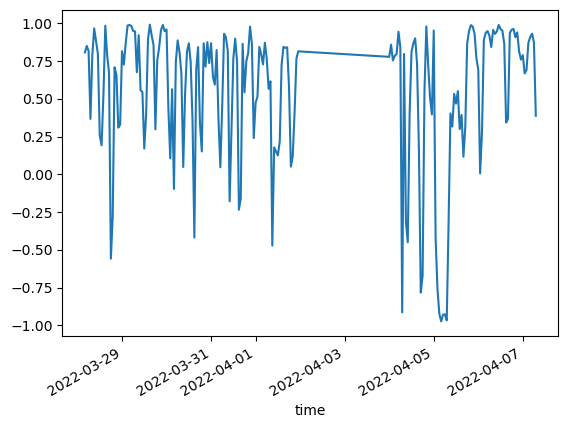

In [5]:
window_size = 5  # Change this to the size of the window you want
combined_df['rolling_corr'] = combined_df['EURUSD_close'].rolling(window=window_size).corr(combined_df['GBPUSD_close'])
combined_df['rolling_corr'].iloc[0:200].plot()

In [6]:
combined_df['EURUSD_return'] = combined_df['EURUSD_close'].pct_change()
combined_df['GBPUSD_return'] = combined_df['GBPUSD_close'].pct_change()
combined_df['diff'] = combined_df['EURUSD_return'] - combined_df['GBPUSD_return']
combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
adf_test(combined_df['rolling_corr_returns'].dropna())

{'ADF Statistic': -35.07636530915757,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.431005015196264,
  '5%': -2.8618294777083033,
  '10%': -2.5669240838467666}}

<AxesSubplot:xlabel='time'>

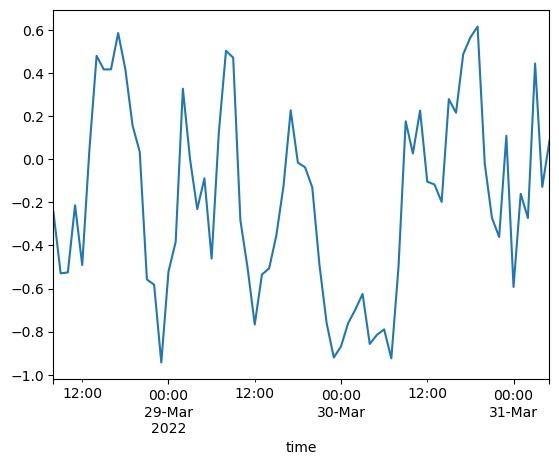

In [7]:
combined_df['rolling_corr_returns'].iloc[8:78].plot()

In [8]:
EU_GU = combined_df

In [85]:
def get_pair_correlations(symbol1, symbol2, window):
    s1 = str(symbol1)
    s2 = str(symbol2)
    symbol1 = get_rates(symbol1, mt5.TIMEFRAME_H4, 5000)
    symbol2 = get_rates(symbol2, mt5.TIMEFRAME_H4, 5000)

    combined_df = pd.concat([symbol1['close'].rename(f'{s1}_close'),
                            symbol2['close'].rename(f'{s2}_close')], axis=1)

    window_size = window  # Change this to the size of the window you want
    combined_df['rolling_corr'] = combined_df[f'{s1}_close'].rolling(window=window_size).corr(combined_df[f'{s2}_close'])
    combined_df['spread'] = combined_df[f'{s1}_close'] - combined_df[f'{s2}_close'] 
    combined_df[f'{s1}_return'] = combined_df[f'{s1}_close'].pct_change()
    combined_df[f'{s2}_return'] = combined_df[f'{s2}_close'].pct_change()
    combined_df['diff'] = combined_df[f'{s1}_return'] - combined_df[f'{s2}_return']
    combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
    combined_df['rolling_var'] = combined_df['EURUSD.a_close'].rolling(window = 25).var()
    combined_df['MA_Ratio'] = combined_df['spread'].rolling(window = 15).mean() / combined_df['spread'].rolling(window = 75).mean()
    return combined_df.dropna()

In [86]:
EU_GU = get_pair_correlations('EURUSD.a', 'GBPUSD.a', 5)

In [87]:
EU_GU

,EURUSD.a_close,GBPUSD.a_close,rolling_corr,spread,EURUSD.a_return,GBPUSD.a_return,diff,rolling_corr_returns,rolling_var,MA_Ratio
time,,,,,,,,,,
2020-09-08 00:00:00,1.18071,1.31523,0.790785,-0.13452,-0.000474,-0.001041,0.000566,0.744417,0.000006,1.009107
2020-09-08 04:00:00,1.18112,1.31374,0.395244,-0.13262,0.000347,-0.001133,0.001480,-0.294585,0.000005,1.004247
2020-09-08 08:00:00,1.18083,1.31047,0.667424,-0.12964,-0.000246,-0.002489,0.002244,-0.603319,0.000003,0.998397
2020-09-08 12:00:00,1.18006,1.30385,0.882098,-0.12379,-0.000652,-0.005052,0.004400,0.268235,0.000003,0.990498
2020-09-08 16:00:00,1.17960,1.30455,0.862044,-0.12495,-0.000390,0.000537,-0.000927,0.016872,0.000003,0.982956
...,...,...,...,...,...,...,...,...,...,...
2023-11-03 04:00:00,1.06264,1.22006,0.823667,-0.15742,0.000772,0.000919,-0.000147,0.629115,0.000011,1.004024
2023-11-03 08:00:00,1.06272,1.21940,0.734229,-0.15668,0.000075,-0.000541,0.000616,-0.289209,0.000011,1.004160
2023-11-03 12:00:00,1.07097,1.23131,0.993759,-0.16034,0.007763,0.009767,-0.002004,-0.730835,0.000015,1.005718


In [91]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(EU_GU[['MA_Ratio', 'spread']], 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8019  , p=0.0052  , df_denom=4922, df_num=1
ssr based chi2 test:   chi2=7.8067  , p=0.0052  , df=1
likelihood ratio test: chi2=7.8005  , p=0.0052  , df=1
parameter F test:         F=7.8019  , p=0.0052  , df_denom=4922, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6893  , p=0.0680  , df_denom=4919, df_num=2
ssr based chi2 test:   chi2=5.3841  , p=0.0677  , df=2
likelihood ratio test: chi2=5.3811  , p=0.0678  , df=2
parameter F test:         F=2.6893  , p=0.0680  , df_denom=4919, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1368  , p=0.0001  , df_denom=4916, df_num=3
ssr based chi2 test:   chi2=21.4409 , p=0.0001  , df=3
likelihood ratio test: chi2=21.3944 , p=0.0001  , df=3
parameter F test:         F=7.1368  , p=0.0001  , df_denom=4916, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.9349  , p=0.

{1: ({'ssr_ftest': (7.801915958669016, 0.005239254005454084, 4922.0, 1),
   'ssr_chi2test': (7.806671291435373, 0.005205370046323098, 1),
   'lrtest': (7.800490601992351, 0.005223205089781583, 1),
   'params_ftest': (7.801915958665876, 0.00523925400546601, 4922.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.689309316061995, 0.06802771445953075, 4919.0, 2),
   'ssr_chi2test': (5.384085819186527, 0.06774240630296713, 2),
   'lrtest': (5.381144382743514, 0.06784210959403744, 2),
   'params_ftest': (2.689309316037545, 0.06802771446120229, 4919.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.136819524319416, 8.836181678089773e-05, 4916.0, 3),
   'ssr_chi2test': (21.440945393546272, 8.525453732020563e-05, 3),
   'lrtest': (21.394390071480302, 8.717535835032911e-05, 3),
   'params_ftest': (7.1368195243107735, 8.836181678201044e-05, 4916.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
   

In [92]:
EU_GU

,EURUSD.a_close,GBPUSD.a_close,rolling_corr,spread,EURUSD.a_return,GBPUSD.a_return,diff,rolling_corr_returns,rolling_var,MA_Ratio
time,,,,,,,,,,
2020-09-08 00:00:00,1.18071,1.31523,0.790785,-0.13452,-0.000474,-0.001041,0.000566,0.744417,0.000006,1.009107
2020-09-08 04:00:00,1.18112,1.31374,0.395244,-0.13262,0.000347,-0.001133,0.001480,-0.294585,0.000005,1.004247
2020-09-08 08:00:00,1.18083,1.31047,0.667424,-0.12964,-0.000246,-0.002489,0.002244,-0.603319,0.000003,0.998397
2020-09-08 12:00:00,1.18006,1.30385,0.882098,-0.12379,-0.000652,-0.005052,0.004400,0.268235,0.000003,0.990498
2020-09-08 16:00:00,1.17960,1.30455,0.862044,-0.12495,-0.000390,0.000537,-0.000927,0.016872,0.000003,0.982956
...,...,...,...,...,...,...,...,...,...,...
2023-11-03 04:00:00,1.06264,1.22006,0.823667,-0.15742,0.000772,0.000919,-0.000147,0.629115,0.000011,1.004024
2023-11-03 08:00:00,1.06272,1.21940,0.734229,-0.15668,0.000075,-0.000541,0.000616,-0.289209,0.000011,1.004160
2023-11-03 12:00:00,1.07097,1.23131,0.993759,-0.16034,0.007763,0.009767,-0.002004,-0.730835,0.000015,1.005718


In [182]:
granger_df = pd.DataFrame()
for i in range(1,4):
    granger_df[f'MA_Ratio_{i}'] = EU_GU['MA_Ratio'].shift(i)

for i in range(6, 9):
    granger_df[f'rolling_corr_ret_{i}'] = EU_GU['rolling_corr_returns'].shift(i)

granger_df['rolling_var_3'] = EU_GU['rolling_var'].shift(3)
granger_df['rolling_var_4'] = EU_GU['rolling_var'].shift(4)
granger_df['spread'] = EU_GU['spread']
granger_df = granger_df.dropna()

In [183]:
granger_df

,MA_Ratio_1,MA_Ratio_2,MA_Ratio_3,rolling_corr_ret_6,rolling_corr_ret_7,rolling_corr_ret_8,rolling_var_3,rolling_var_4,spread
time,,,,,,,,,
2020-09-09 08:00:00,0.953893,0.963520,0.972882,-0.603319,-0.294585,0.744417,0.000004,0.000003,-0.11760
2020-09-09 12:00:00,0.941980,0.953893,0.963520,0.268235,-0.603319,-0.294585,0.000005,0.000004,-0.11610
2020-09-09 16:00:00,0.930714,0.941980,0.953893,0.016872,0.268235,-0.603319,0.000006,0.000005,-0.12100
2020-09-09 20:00:00,0.922436,0.930714,0.941980,0.194513,0.016872,0.268235,0.000007,0.000006,-0.11964
2020-09-10 00:00:00,0.915294,0.922436,0.930714,-0.000353,0.194513,0.016872,0.000007,0.000007,-0.11836
...,...,...,...,...,...,...,...,...,...
2023-11-03 04:00:00,1.003372,1.001644,0.998995,0.244714,0.733098,0.754557,0.000010,0.000010,-0.15742
2023-11-03 08:00:00,1.004024,1.003372,1.001644,0.040605,0.244714,0.733098,0.000011,0.000010,-0.15668
2023-11-03 12:00:00,1.004160,1.004024,1.003372,-0.824453,0.040605,0.244714,0.000011,0.000011,-0.16034


In [129]:
features = ['MA_Ratio_1', 'MA_Ratio_2', 'MA_Ratio_3', 'rolling_corr_ret_6', 'rolling_corr_ret_7', 'rolling_corr_ret_8', 'rolling_var_3', 'rolling_var_4']
target = 'spread'

In [130]:
# import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# import yfinance as yf
import pandas_ta as ta
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [136]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(granger_df[features], granger_df[target], test_size=0.1, random_state=42)

# Create and train a multiple regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [137]:
# Predict the exchange rates using the trained model
granger_df['Predicted_Spread'] = model.predict(granger_df[features])

In [153]:
def direction_of_change(values):
    # Calculate the difference between consecutive values
    diff = values.diff()
    # Determine the direction
    direction = diff.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    return direction


In [152]:
results = granger_df[['spread', 'Predicted_Spread']]
results['spread_change'] = results['spread'].pct_change()
results['Predicted_Spread_change'] = results['Predicted_Spread'].pct_change()
results = results.dropna()
results

,spread,Predicted_Spread,spread_change,Predicted_Spread_change
time,,,,
2020-09-09 12:00:00,-0.11610,-0.164505,-0.012755,-0.022333
2020-09-09 16:00:00,-0.12100,-0.163979,0.042205,-0.003194
2020-09-09 20:00:00,-0.11964,-0.166150,-0.011240,0.013238
2020-09-10 00:00:00,-0.11836,-0.164148,-0.010699,-0.012048
2020-09-10 04:00:00,-0.11722,-0.163488,-0.009632,-0.004021
...,...,...,...,...
2023-11-03 04:00:00,-0.15742,-0.177564,0.001909,-0.010070
2023-11-03 08:00:00,-0.15668,-0.177011,-0.004701,-0.003114
2023-11-03 12:00:00,-0.16034,-0.175716,0.023360,-0.007316


In [157]:
results['Direction_Spread'] = direction_of_change(results['spread'])
results['Direction_Predicted_Spread'] = direction_of_change(results['Predicted_Spread'])
results[['Direction_Spread', 'Direction_Predicted_Spread']]

,Direction_Spread,Direction_Predicted_Spread
time,,
2020-09-09 12:00:00,0,0
2020-09-09 16:00:00,-1,1
2020-09-09 20:00:00,1,-1
2020-09-10 00:00:00,1,1
2020-09-10 04:00:00,1,1
...,...,...
2023-11-03 04:00:00,-1,1
2023-11-03 08:00:00,1,1
2023-11-03 12:00:00,-1,1


In [178]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# assuming resultss is your dataframe and 'Direction_Spread' and 'Direction_Predicted_Spread' are your column names
accuracy = accuracy_score(results['Direction_Spread'], results['Direction_Predicted_Spread'])
precision = precision_score(results['Direction_Spread'], results['Direction_Predicted_Spread'], average='macro')
recall = recall_score(results['Direction_Spread'], results['Direction_Predicted_Spread'], average = 'macro')
f1 = f1_score(results['Direction_Spread'], results['Direction_Predicted_Spread'], average = 'macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.49644091925971123
Precision: 0.6641776880880372
Recall: 0.37886382623224724
F1 Score: 0.4143474171275496


In [179]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np


In [185]:
df = granger_df

In [186]:
X = df.drop('spread', axis=1)
y = df['spread']

In [197]:
# Split the data into training and testing sets for Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest MSE: {rf_mse}")


Random Forest MSE: 0.000636453983509756


In [199]:
accuracy_score(y_test, rf_predictions)

ValueError: continuous is not supported

In [196]:
train_size = int(len(y) * 0.8)
train, test = y[0:train_size], y[train_size:]

# Fit the ARIMA model (you may need to choose the order (p,d,q) based on your data)
# For this example, let's use (1,0,1) as a placeholder
arima_model = ARIMA(train, order=(1, 0, 1))
arima_model_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_model_fit.forecast(steps=len(test))

# Calculate the mean squared error
arima_mse = mean_squared_error(test, arima_predictions)
print(f"ARIMA MSE: {arima_mse}")

ARIMA MSE: 0.00012385714616420515


In [189]:
granger_df

,MA_Ratio_1,MA_Ratio_2,MA_Ratio_3,rolling_corr_ret_6,rolling_corr_ret_7,rolling_corr_ret_8,rolling_var_3,rolling_var_4,spread
time,,,,,,,,,
2020-09-09 08:00:00,0.953893,0.963520,0.972882,-0.603319,-0.294585,0.744417,0.000004,0.000003,-0.11760
2020-09-09 12:00:00,0.941980,0.953893,0.963520,0.268235,-0.603319,-0.294585,0.000005,0.000004,-0.11610
2020-09-09 16:00:00,0.930714,0.941980,0.953893,0.016872,0.268235,-0.603319,0.000006,0.000005,-0.12100
2020-09-09 20:00:00,0.922436,0.930714,0.941980,0.194513,0.016872,0.268235,0.000007,0.000006,-0.11964
2020-09-10 00:00:00,0.915294,0.922436,0.930714,-0.000353,0.194513,0.016872,0.000007,0.000007,-0.11836
...,...,...,...,...,...,...,...,...,...
2023-11-03 04:00:00,1.003372,1.001644,0.998995,0.244714,0.733098,0.754557,0.000010,0.000010,-0.15742
2023-11-03 08:00:00,1.004024,1.003372,1.001644,0.040605,0.244714,0.733098,0.000011,0.000010,-0.15668
2023-11-03 12:00:00,1.004160,1.004024,1.003372,-0.824453,0.040605,0.244714,0.000011,0.000011,-0.16034


<AxesSubplot:xlabel='time'>

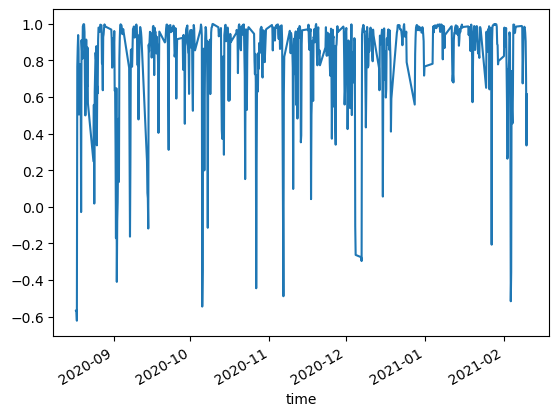

In [61]:
AU_NU = get_pair_correlations('AUDUSD.a', 'NZDUSD.a', 5)
AU_NU['rolling_corr'].iloc[0:750].plot()

In [74]:
AU_NU.corr()

,AUDUSD.a_close,NZDUSD.a_close,rolling_corr,AUDUSD.a_return,NZDUSD.a_return,diff,rolling_corr_returns,shifted_rolling_corr_returns
AUDUSD.a_close,1.000000,0.965848,0.003780,0.030595,0.025639,0.010837,-0.003965,-0.004412
NZDUSD.a_close,0.965848,1.000000,-0.020269,0.027497,0.027517,0.000012,0.010639,0.010365
rolling_corr,0.003780,-0.020269,1.000000,-0.003997,-0.007186,0.006927,-0.006935,0.021117
AUDUSD.a_return,0.030595,0.027497,-0.003997,1.000000,0.894367,0.231720,-0.025514,-0.008409
NZDUSD.a_return,0.025639,0.027517,-0.007186,0.894367,1.000000,-0.227915,0.025736,-0.008155
diff,0.010837,0.000012,0.006927,0.231720,-0.227915,1.000000,-0.111501,-0.000568
rolling_corr_returns,-0.003965,0.010639,-0.006935,-0.025514,0.025736,-0.111501,1.000000,0.598644
shifted_rolling_corr_returns,-0.004412,0.010365,0.021117,-0.008409,-0.008155,-0.000568,0.598644,1.000000


In [75]:
np.cov(AU_NU)

array([[ 0.26115327,  0.16260621,  0.16501692, ...,  0.09746161,
         0.01421638,  0.02092063],
       [ 0.16260621,  0.16480447,  0.17044062, ...,  0.00534735,
         0.0369558 , -0.00433707],
       [ 0.16501692,  0.17044062,  0.1772012 , ..., -0.00332087,
         0.03714966, -0.00650682],
       ...,
       [ 0.09746161,  0.00534735, -0.00332087, ...,  0.19983626,
         0.06579227,  0.13599403],
       [ 0.01421638,  0.0369558 ,  0.03714966, ...,  0.06579227,
         0.08902757,  0.09998917],
       [ 0.02092063, -0.00433707, -0.00650682, ...,  0.13599403,
         0.09998917,  0.15804439]])

<AxesSubplot:xlabel='time'>

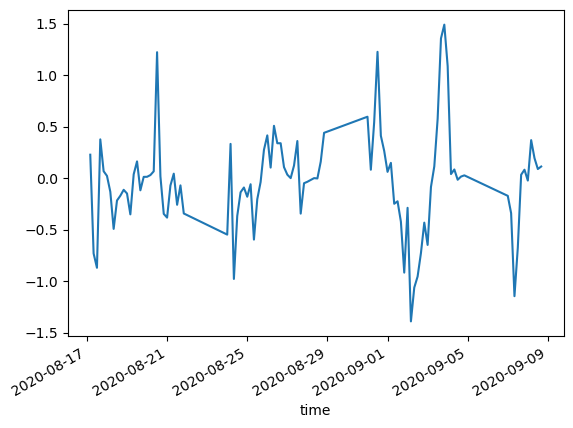

In [51]:
test = (AU_NU['rolling_corr'] - EU_GU['rolling_corr'])
test.iloc[0:100].plot()

## Volatility

In [77]:
import statistics

In [87]:
EU_GU['rolling_var'] = EU_GU['EURUSD.a_close'].rolling(window = 25).var()
EU_GU['shifted_var'] = EU_GU['rolling_var'].shift(1)
EU_GU = EU_GU.dropna()

C:\Users\markp\AppData\Local\Temp\ipykernel_12512\3912485532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_GU['rolling_var'] = EU_GU['EURUSD.a_close'].rolling(window = 25).var()
C:\Users\markp\AppData\Local\Temp\ipykernel_12512\3912485532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_GU['shifted_var'] = EU_GU['rolling_var'].shift(1)


In [95]:
EU_GU[['shifted_var', 'diff']]

,shifted_var,diff
time,,
2020-08-25 20:00:00,0.000009,-0.000295
2020-08-26 00:00:00,0.000008,0.000101
2020-08-26 04:00:00,0.000008,-0.000894
2020-08-26 08:00:00,0.000008,-0.001304
2020-08-26 12:00:00,0.000007,-0.000406
...,...,...
2023-10-27 04:00:00,0.000018,0.000023
2023-10-27 08:00:00,0.000018,0.000296
2023-10-27 12:00:00,0.000019,-0.000814


In [94]:
EU_GU[['shifted_var', 'diff']].corr()

,shifted_var,diff
shifted_var,1.000000,-0.008661
diff,-0.008661,1.000000


In [93]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(EU_GU[['shifted_var', 'diff']], 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.5936 , p=0.0000  , df_denom=4947, df_num=1
ssr based chi2 test:   chi2=17.6042 , p=0.0000  , df=1
likelihood ratio test: chi2=17.5730 , p=0.0000  , df=1
parameter F test:         F=17.5936 , p=0.0000  , df_denom=4947, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.6254  , p=0.0005  , df_denom=4944, df_num=2
ssr based chi2 test:   chi2=15.2663 , p=0.0005  , df=2
likelihood ratio test: chi2=15.2428 , p=0.0005  , df=2
parameter F test:         F=7.6254  , p=0.0005  , df_denom=4944, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5333  , p=0.0001  , df_denom=4941, df_num=3
ssr based chi2 test:   chi2=22.6318 , p=0.0000  , df=3
likelihood ratio test: chi2=22.5802 , p=0.0000  , df=3
parameter F test:         F=7.5333  , p=0.0001  , df_denom=4941, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9382  , p=0.

{1: ({'ssr_ftest': (17.593569288270537, 2.7829744290187754e-05, 4947.0, 1),
   'ssr_chi2test': (17.60423852373947, 2.719814839331614e-05, 1),
   'lrtest': (17.573008585182833, 2.764849733692958e-05, 1),
   'params_ftest': (17.593569288271233, 2.782974429017248e-05, 4947.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.625430681520601, 0.0004936451352256021, 4944.0, 2),
   'ssr_chi2test': (15.266284968788614, 0.0004841370721632451, 2),
   'lrtest': (15.242787163122557, 0.0004898586971740638, 2),
   'params_ftest': (7.62543068148382, 0.0004936451352438352, 4944.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.533255815021851, 5.010150177554462e-05, 4941.0, 3),
   'ssr_chi2test': (22.63178492576085, 4.8186359035413456e-05, 3),
   'lrtest': (22.580184158694465, 4.939378836333214e-05, 3),
   'params_ftest': (7.533255815021984, 5.010150177553972e-05, 4941.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.,